### ***For Google Colab***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install torchinfo timm einops

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
cd /content/drive/MyDrive/HistographicMAE_Experiments

/content/drive/MyDrive/HistographicMAE_Experiments


### ***Import Library and Setting***

In [ ]:
import os
from pathlib import Path
import sys

# For Google Colab and Project/test.ipynb
project_path = str(Path().absolute())

if project_path not in sys.path:
    sys.path.append(project_path)

os.listdir(project_path)

['Experimental Results',
 'Database_raw',
 'Database_compressed',
 'img_preprocess.ipynb',
 'src',
 'main.ipynb']

In [ ]:

import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
import torchvision.transforms as transforms
import timm
from timm.models.layers import trunc_normal_
from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

from src.models import MAE, ViT
from src.utils import plot_train_curve, plot_confusion_matrix
from src.utils import seed_setting, get_crop_file_path, get_cropped_images
from src.utils import train, ssl_train, test

database_dir = project_path + '/Database_compressed'
train_dir = database_dir + '/train_thumbnails'
# test_dir = database_dir + '/test_thumbnails'
results_dir = project_path + '/Experimental Results'

PROJECT_NAME = 'MAE'
current_result_dir = results_dir + '/' + PROJECT_NAME + '/'
os.makedirs(current_result_dir, exist_ok=True)

In [ ]:
class CONFIG:
    def __init__(self, name):
        self.seed = 2024
        seed_setting(self.seed)

        self.model_name = name
        self.initialize_parameters()
        self.print_config()

    def initialize_parameters(self):
        self.cpu_worker = multiprocessing.cpu_count()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.batch_size = 32
        self.num_classes = 5
        self.img_size = 224

        self.class2label = ['HGSC', 'EC', 'CC', 'LGSC', 'MC']

    def print_config(self):
        print(f'======== Project: {self.model_name} ========' )
        print('Set same seed for numpy and torch:', self.seed)
        print('\nCPU Worker:', self.cpu_worker)
        # Check Cuda version
        print('\nTorch version: ', torch.__version__)
        print('Torch CUDA version: ', torch.version.cuda)
        print('CUDA available? :  ', torch.cuda.is_available())
        print('\nClass: ', self.class2label)

config = CONFIG(PROJECT_NAME)

======== Project: MAE ========
Set same seed for numpy and torch: 2024

CPU Worker: 8

Torch version:  2.1.0+cu121
Torch CUDA version:  12.1
CUDA available? :   True

Class:  ['HGSC', 'EC', 'CC', 'LGSC', 'MC']


In [ ]:

df_dataset = pd.read_csv(f"{database_dir}/train_crop_resize.csv")
df_dataset['file_path'] = df_dataset.apply(lambda row: get_crop_file_path(train_dir, row['image_id'], row['crop_id']), axis=1)
df_dataset.head()

,image_id,crop_id,file_path,class,label,sx_in_raw,ex_in_raw,sy_in_raw,ey_in_raw
0,4,0,/content/drive/MyDrive/HistographicMAE_Experim...,HGSC,0,0,2999,0,2522
1,66,0,/content/drive/MyDrive/HistographicMAE_Experim...,LGSC,3,0,2999,0,2957
2,281,0,/content/drive/MyDrive/HistographicMAE_Experim...,LGSC,3,0,1101,0,1101
3,281,1,/content/drive/MyDrive/HistographicMAE_Experim...,LGSC,3,1898,2999,0,1101
4,286,0,/content/drive/MyDrive/HistographicMAE_Experim...,EC,1,0,2999,0,2419


Total: 773
HGSC    339
EC      160
CC      149
LGSC     69
MC       56
Name: class, dtype: int64


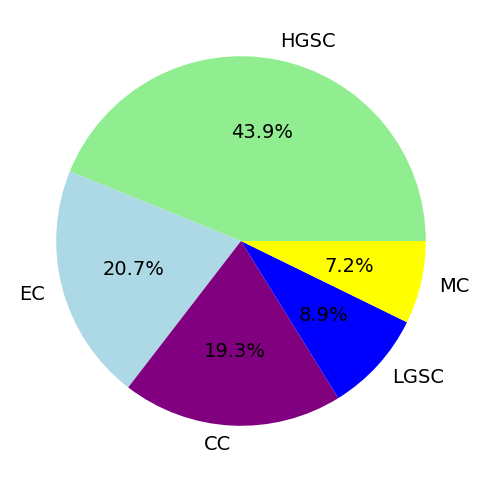

In [ ]:
print('Total:', len(df_dataset))
print(df_dataset['class'].value_counts())

# Plot the pie chart for the training set
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 14
colors = ['lightgreen', 'lightblue', 'purple', 'blue', 'yellow']

plt.subplot(1, 1, 1)
HGSC = df_dataset[df_dataset['class']=="HGSC"]
EC = df_dataset[df_dataset['class']=="EC"]
CC = df_dataset[df_dataset['class']=="CC"]
LGSC = df_dataset[df_dataset['class']=="LGSC"]
MC = df_dataset[df_dataset['class']=="MC"]
plt.pie([len(HGSC), len(EC), len(CC), len(LGSC), len(MC)], labels=['HGSC', 'EC', 'CC', 'LGSC', 'MC'], autopct='%1.1f%%', colors=colors)
plt.show()

In [ ]:
# split dataset
print('Crop dataset size:', len(df_dataset))
print(df_dataset['class'].value_counts())

df_train, temp_test = train_test_split(df_dataset, test_size=0.3, random_state=config.seed)
df_val, df_test = train_test_split(temp_test, test_size=0.5, random_state=config.seed)

print('\nTrain dataset size:', len(df_train))
print(df_train['class'].value_counts())
print('\nValidation dataset size:', len(df_val))
print(df_val['class'].value_counts())
print('\nTest dataset size:', len(df_test))
print(df_test['class'].value_counts())

train_img_list = []
for img_path in tqdm(df_train['file_path']):
    image = Image.open(img_path).convert('RGB')
    train_img_list.append(image)
df_train['img'] = train_img_list

val_img_list = []
for img_path in tqdm(df_val['file_path']):
    image = Image.open(img_path).convert('RGB')
    val_img_list.append(image)
df_val['img'] = val_img_list

test_img_list = []
for img_path in tqdm(df_test['file_path']):
    image = Image.open(img_path).convert('RGB')
    test_img_list.append(image)
df_test['img'] = test_img_list

Crop dataset size: 773
HGSC    339
EC      160
CC      149
LGSC     69
MC       56
Name: class, dtype: int64

Train dataset size: 541
HGSC    234
CC      109
EC      107
LGSC     52
MC       39
Name: class, dtype: int64

Validation dataset size: 116
HGSC    50
EC      24
CC      19
MC      14
LGSC     9
Name: class, dtype: int64

Test dataset size: 116
HGSC    55
EC      29
CC      21
LGSC     8
MC       3
Name: class, dtype: int64


  0%|          | 0/541 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    "train": transforms.Compose([transforms.Resize(256),
                                 transforms.RandomResizedCrop((config.img_size),scale=(0.5,1.0)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize]),

    "val": transforms.Compose([transforms.Resize(config.img_size),
                                 transforms.CenterCrop(config.img_size),
                                 transforms.ToTensor(),
                                 normalize])
    }

In [ ]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.labels = df['label'].values
        self.img_list = df['img'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = self.labels[index]
        img = self.img_list[index]

        if self.transforms:
            img = self.transforms(img)

        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
train_dataset = UBCDataset(df_train, transforms=data_transforms["train"])
val_dataset = UBCDataset(df_val, transforms=data_transforms["val"])
test_dataset = UBCDataset(df_test, transforms=data_transforms["val"])

train_loader = DataLoader(train_dataset,
                          batch_size = config.batch_size,
                          num_workers = config.cpu_worker, #config.cpu_worker
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                          batch_size = config.batch_size,
                          num_workers = config.cpu_worker, #config.cpu_worker
                          shuffle=False,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                          batch_size = config.batch_size,
                          num_workers = config.cpu_worker, #config.cpu_worker
                          shuffle=False,
                          pin_memory=True)

### ***SSL Pre-train and Val***

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # we use xavier_uniform following official JAX ViT:
        torch.nn.init.xavier_uniform_(m.weight)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)


def ssl_train(train_loader, val_loader, model, Param, folder_dir:str):
    train_losses = []
    val_losses = []
    lr_epoch = Param['LR']
    EPOCH = Param['EPOCH']
    exp_name = Param['Exp_name']
    best_loss = 1000

    device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model.apply(initialize_weights)
    bestmodel_dir = folder_dir + f'Best_{exp_name}.pkl'

    epoch_start_time = time.time()
    for epoch in range(EPOCH):
        train_loss = 0
        val_loss = 0

        """ Training """
        model.train()
        for batch_index, batch_samples in enumerate(train_loader):
            data, label = batch_samples['image'].to(device), batch_samples['label'].to(device)

            optimizer.zero_grad()
            loss = model(data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        """ Validation """
        model.eval()
        with torch.no_grad():
            for batch_index, batch_samples in enumerate(val_loader):
                data, label = batch_samples['image'].to(device), batch_samples['label'].to(device)
                loss = model(data)
                val_loss += loss.item()

        train_losses.append(train_loss / len(train_loader.dataset))
        val_losses.append(val_loss / len(val_loader.dataset))

        if (val_losses[epoch] < best_loss) and epoch>(EPOCH/2):
            best_loss = val_losses[epoch]
            best_epoch = epoch
            torch.save(model.eval(), bestmodel_dir)

        epoch_end_time = time.time()
        time_interval = epoch_end_time - epoch_start_time
        print(
            '\r[{:03d}/{:03d} Time: {:4.2f}s LR: {:3.8f}] Train Loss: {:.4f} | Val loss: {:.4f}'.format(
            epoch, EPOCH, time_interval, lr_epoch, train_losses[epoch], val_losses[epoch]),
            end=''
            )

        if Param['LRScheduler'] == 'ReduceLROnPlateau':
            lr_scheduler.step(val_losses[epoch])
        lr_epoch = optimizer.param_groups[-1]['lr']


    print('\nThe best epoch: {}th  -->  Val Loss: {:.4f}'.format(best_epoch, val_losses[best_epoch]) )
    plot_train_curve(EPOCH, train_losses, val_losses,
                     curve_type='Loss', title=exp_name, folder_path=folder_dir, fig_size=(8,6), save_img=True)


[099/100 Time: 1090.55s LR: 0.00010000] Train Loss: 0.0135 | Val loss: 0.0173
The best epoch: 99th  -->  Val Loss: 0.0173


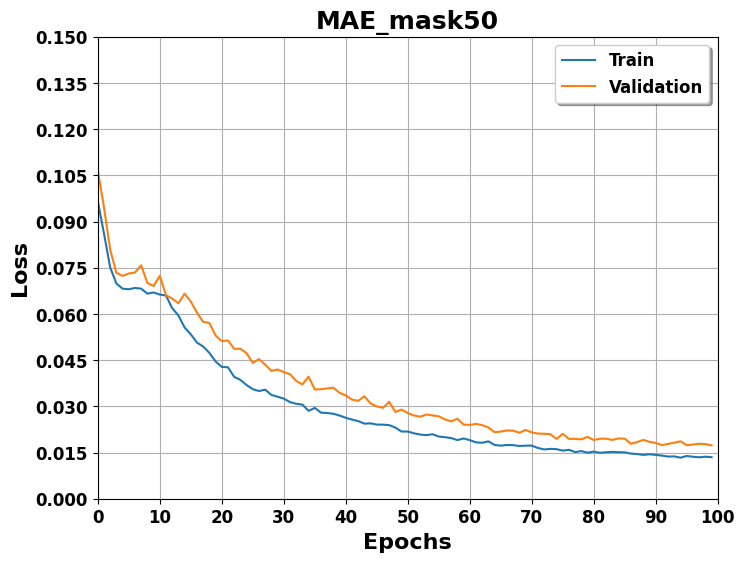

In [ ]:
# Masking ratio 50%

Param = {'Exp_name': 'MAE_mask50',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

v = ViT(image_size = config.img_size, # 224
        patch_size = 16,
        num_classes = config.num_classes, # 5
        dim = 1024,
        depth = 6,
        heads = 8,
        mlp_dim = 2048
        )

mae = MAE(encoder = v,
          masking_ratio = 0.50,
          decoder_dim = 512,
          decoder_depth = 6
          )

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae = mae.to(device)
optimizer = optim.AdamW(mae.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

ssl_train(train_loader, val_loader, mae, Param, folder_dir = current_result_dir)

[099/100 Time: 1021.77s LR: 0.00010000] Train Loss: 0.0150 | Val loss: 0.0186
The best epoch: 99th  -->  Val Loss: 0.0186


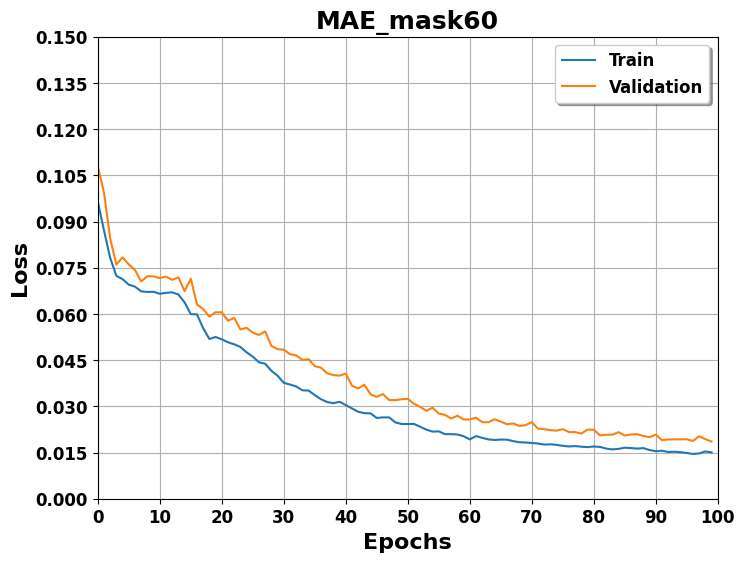

In [ ]:
# Masking ratio 60%

Param = {'Exp_name': 'MAE_mask60',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

v = ViT(image_size = config.img_size,
        patch_size = 16,
        num_classes = config.num_classes,
        dim = 1024,
        depth = 6,
        heads = 8,
        mlp_dim = 2048
        )

mae = MAE(encoder = v,
          masking_ratio = 0.60,
          decoder_dim = 512,
          decoder_depth = 6
          )

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae = mae.to(device)
optimizer = optim.AdamW(mae.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

ssl_train(train_loader, val_loader, mae, Param, folder_dir = current_result_dir)

[099/100 Time: 931.61s LR: 0.00010000] Train Loss: 0.0165 | Val loss: 0.0213
The best epoch: 96th  -->  Val Loss: 0.0207


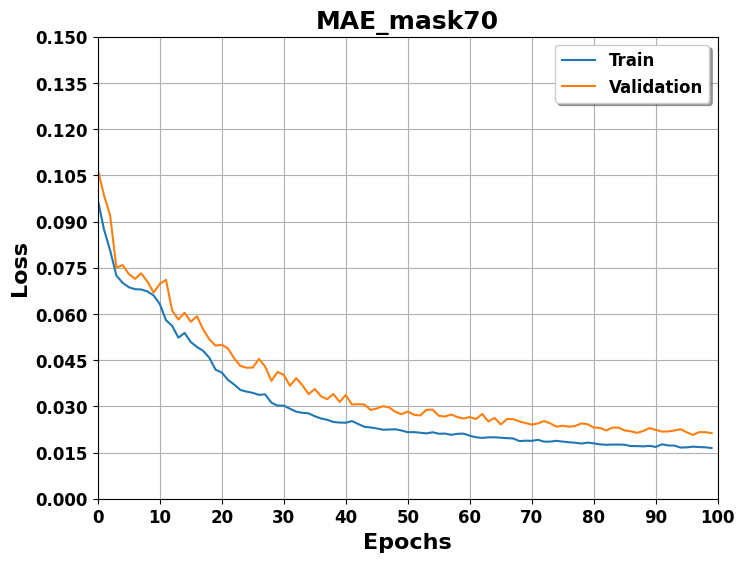

In [ ]:
# Masking ratio 70%

Param = {'Exp_name': 'MAE_mask70',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

v = ViT(image_size = config.img_size,
        patch_size = 16,
        num_classes = config.num_classes,
        dim = 1024,
        depth = 6,
        heads = 8,
        mlp_dim = 2048
        )

mae = MAE(encoder = v,
          masking_ratio = 0.70,
          decoder_dim = 512,
          decoder_depth = 6
          )

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae = mae.to(device)
optimizer = optim.AdamW(mae.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

ssl_train(train_loader, val_loader, mae, Param, folder_dir = current_result_dir)

[099/100 Time: 904.19s LR: 0.00010000] Train Loss: 0.0187 | Val loss: 0.0239
The best epoch: 91th  -->  Val Loss: 0.0234


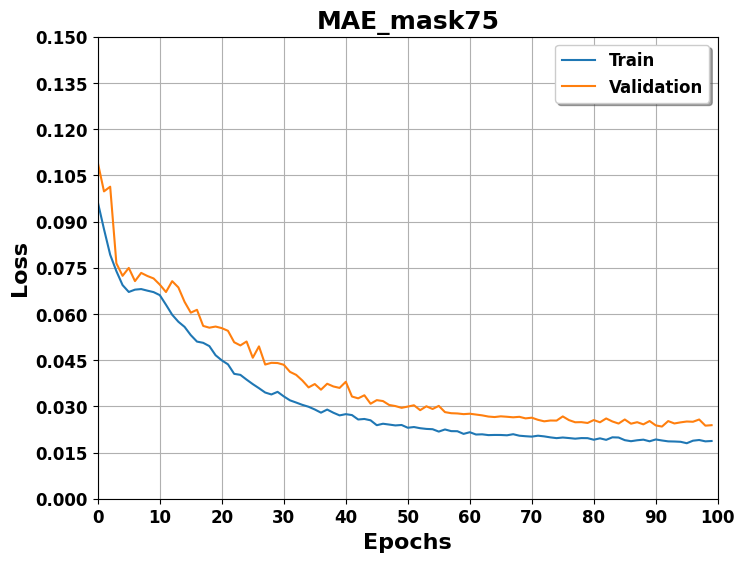

In [ ]:
# Masking ratio 75%

Param = {'Exp_name': 'MAE_mask75',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

v = ViT(image_size = config.img_size,
        patch_size = 16,
        num_classes = config.num_classes,
        dim = 1024,
        depth = 6,
        heads = 8,
        mlp_dim = 2048
        )

mae = MAE(encoder = v,
          masking_ratio = 0.75,
          decoder_dim = 512,
          decoder_depth = 6
          )

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae = mae.to(device)
optimizer = optim.AdamW(mae.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

ssl_train(train_loader, val_loader, mae, Param, folder_dir = current_result_dir)

[099/100 Time: 852.25s LR: 0.00010000] Train Loss: 0.0198 | Val loss: 0.0256
The best epoch: 98th  -->  Val Loss: 0.0247


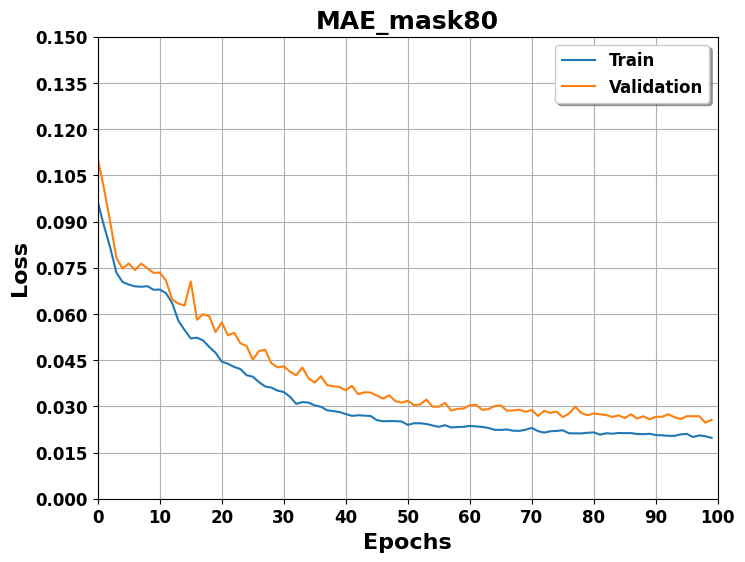

In [ ]:
# Masking ratio 80%

Param = {'Exp_name': 'MAE_mask80',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

v = ViT(image_size = config.img_size,
        patch_size = 16,
        num_classes = config.num_classes,
        dim = 1024,
        depth = 6,
        heads = 8,
        mlp_dim = 2048
        )

mae = MAE(encoder = v,
          masking_ratio = 0.80,
          decoder_dim = 512,
          decoder_depth = 6
          )

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae = mae.to(device)
optimizer = optim.AdamW(mae.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

ssl_train(train_loader, val_loader, mae, Param, folder_dir = current_result_dir)

[099/100 Time: 766.26s LR: 0.00010000] Train Loss: 0.0297 | Val loss: 0.0383
The best epoch: 89th  -->  Val Loss: 0.0354


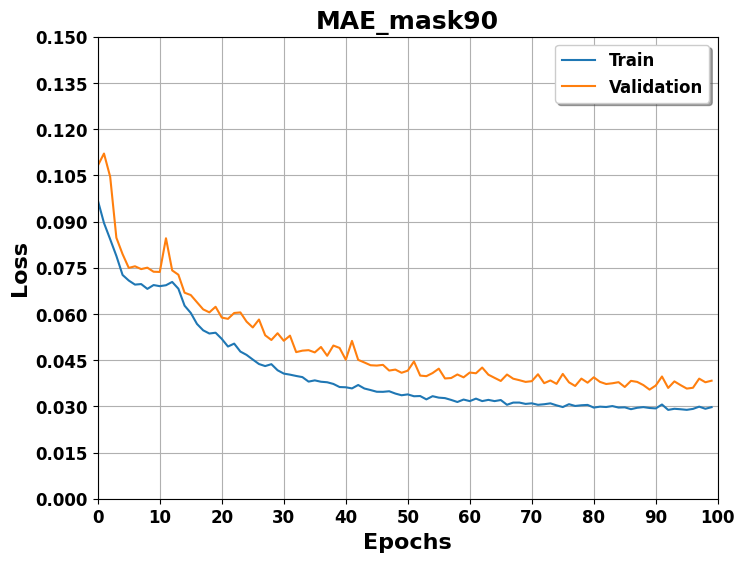

In [ ]:
# Masking ratio 90%

Param = {'Exp_name': 'MAE_mask90',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

v = ViT(image_size = config.img_size,
        patch_size = 16,
        num_classes = config.num_classes,
        dim = 1024,
        depth = 6,
        heads = 8,
        mlp_dim = 2048
        )

mae = MAE(encoder = v,
          masking_ratio = 0.90,
          decoder_dim = 512,
          decoder_depth = 6
          )

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae = mae.to(device)
optimizer = optim.AdamW(mae.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

ssl_train(train_loader, val_loader, mae, Param, folder_dir = current_result_dir)

### ***Classification Tasks***


In [16]:
def initialize_weights_cnn(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [24]:
def train(train_loader, val_loader, model, Param, loss_func, optimizer, folder_dir:str):
    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []
    lr_epoch = Param['LR']
    EPOCH = Param['EPOCH']
    exp_name = Param['Exp_name']
    best_acc = 0
    best_loss = 1000

    device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    bestmodel_dir = folder_dir + f'Best_{exp_name}.pkl'

    epoch_start_time = time.time()
    for epoch in range(EPOCH):
        train_loss = 0
        train_correct = 0
        val_loss = 0
        val_correct = 0

        """ Training """
        model.train()
        for batch_index, batch_samples in enumerate(train_loader):
            data, label = batch_samples['image'].to(device), batch_samples['label'].to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(label.long().view_as(pred)).sum().item()
            train_loss += loss.item()

        """ Validation """
        model.eval()
        with torch.no_grad():
            for batch_index, batch_samples in enumerate(val_loader):
                data, label = batch_samples['image'].to(device), batch_samples['label'].to(device)
                output = model(data)
                val_loss += loss_func(output, label).item()
                #score = F.softmax(output, dim=1)
                pred = output.argmax(dim=1, keepdim=True)
                val_correct += pred.eq(label.long().view_as(pred)).sum().item()


        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracy.append(train_correct / len(train_loader.dataset))
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracy.append(val_correct / len(val_loader.dataset))

        if (val_accuracy[epoch] >= best_acc) and epoch>(EPOCH/2):
            best_acc = val_accuracy[epoch]
            best_loss = val_losses[epoch]
            best_epoch = epoch
            torch.save(model.eval(), bestmodel_dir)

        epoch_end_time = time.time()
        time_interval = epoch_end_time - epoch_start_time
        print(
            '\r[{:03d}/{:03d} Time: {:4.2f}s LR: {:3.8f}] Train Acc: {}/{}({:.2f}%) Loss: {:.4f} | Val Acc: {}/{}({:.2f}%) loss: {:.4f}'.format(
            epoch, EPOCH, time_interval, lr_epoch,
            train_correct, len(train_loader.dataset), 100.0*train_accuracy[epoch], train_losses[epoch],
            val_correct, len(val_loader.dataset), 100.0*val_accuracy[epoch], val_losses[epoch]),
            end=''
            )

        if Param['LRScheduler'] == 'ReduceLROnPlateau':
            lr_scheduler.step(val_losses[epoch])
        lr_epoch = optimizer.param_groups[-1]['lr']


    print('\nThe best epoch: {}th  -->  Val Acc: {:.2f} | Val Loss: {:.4f}'.format(
        best_epoch, 100.0*val_accuracy[best_epoch], val_losses[best_epoch]))

    plot_train_curve(EPOCH, train_accuracy, val_accuracy,
                     curve_type='Accuracy', title=exp_name, folder_path=folder_dir, fig_size=(8,6), save_img=True)
    plot_train_curve(EPOCH, train_losses, val_losses,
                     curve_type='Loss', title=exp_name, folder_path=folder_dir, fig_size=(8,6), save_img=True)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from src.utils.plot_curve import plot_confusion_matrix

def test(test_loader, model, class_name, folder_path:str, plot_name:str):
    logits = []
    y_true = []
    y_pred = []
    test_loss = 0
    test_correct = 0

    device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    model.eval()
    with torch.no_grad():
        for batch_index, batch_samples in enumerate(test_loader):
            data, label = batch_samples['image'].to(device), batch_samples['label'].to(device)
            output = model(data)
            test_loss += loss_func(output, label).item()
            pred = output.argmax(dim=1, keepdim=True)
            test_correct += pred.eq(label.long().view_as(pred)).sum().item()

            # for evaluation
            logits.append(output.detach().cpu().numpy())
            y_true.append(label.detach().cpu().numpy())
            y_pred.append(pred.squeeze(1).detach().cpu().numpy())

    """ Classificatio Report and Confusion Matrix """
    print('Testset Acc: {}/{} ({:.2f}%)'.format(test_correct, len(test_loader.dataset), 100.0*test_correct/len(test_loader.dataset)))
    print('Testset Loss: {:.4f}\n'.format(test_loss/len(test_loader.dataset)))

    logits = np.concatenate(logits, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0) # [ np[1, 2, 3, 4, ... 16], np[], np[] .... ]  -> [1, 2, 3, 4, ... 16, 17, 18, ... 32 ...]
    CM = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=class_name, digits=4))
    print('\nConfusion Matrix: \n', CM)

    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(  CM, classes=class_name, normalize=True, title='Confusion Matrix For Testing Data' )
    plt.tight_layout()
    CM_img_name =  folder_path + 'CM.png'
    plt.savefig(CM_img_name, bbox_inches='tight')

##### ***Train from scratch***

[099/100 Time: 931.70s LR: 0.00005000] Train Acc: 384/541(70.98%) Loss: 0.0238 | Val Acc: 49/116(42.24%) loss: 0.0611
The best epoch: 54th  -->  Val Acc: 49.14 | Val Loss: 0.0528


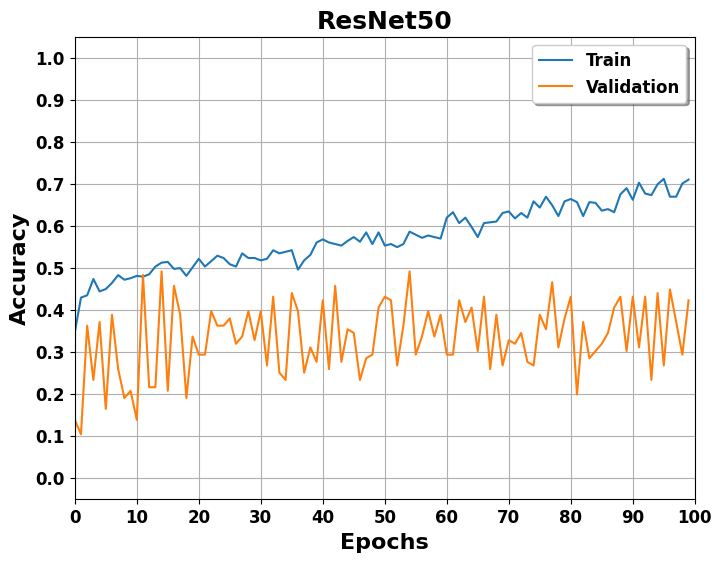

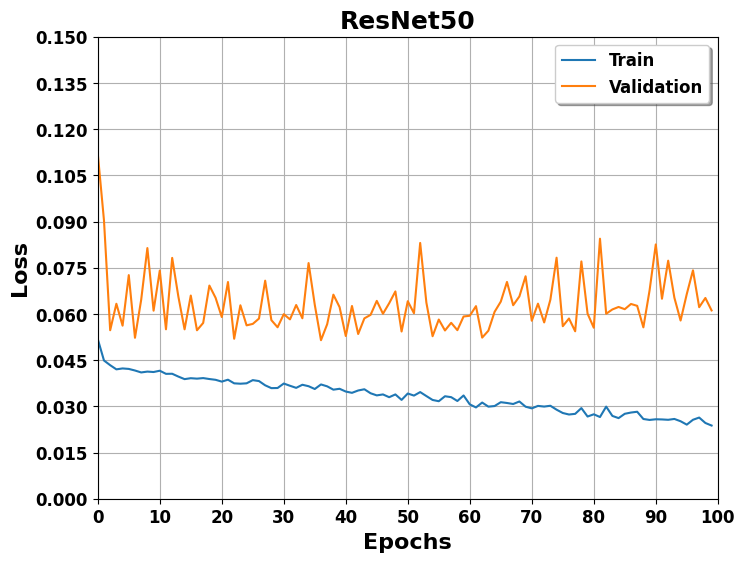

Testset Acc: 62/116 (53.45%)
Testset Loss: 0.0465

              precision    recall  f1-score   support

        HGSC     0.5949    0.8545    0.7015        55
          EC     0.0000    0.0000    0.0000        29
          CC     0.5909    0.6190    0.6047        21
        LGSC     0.0000    0.0000    0.0000         8
          MC     0.1667    0.6667    0.2667         3

    accuracy                         0.5345       116
   macro avg     0.2705    0.4281    0.3146       116
weighted avg     0.3934    0.5345    0.4490       116


Confusion Matrix: 
 [[47  0  4  0  4]
 [22  0  2  2  3]
 [ 7  0 13  0  1]
 [ 2  1  3  0  2]
 [ 1  0  0  0  2]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

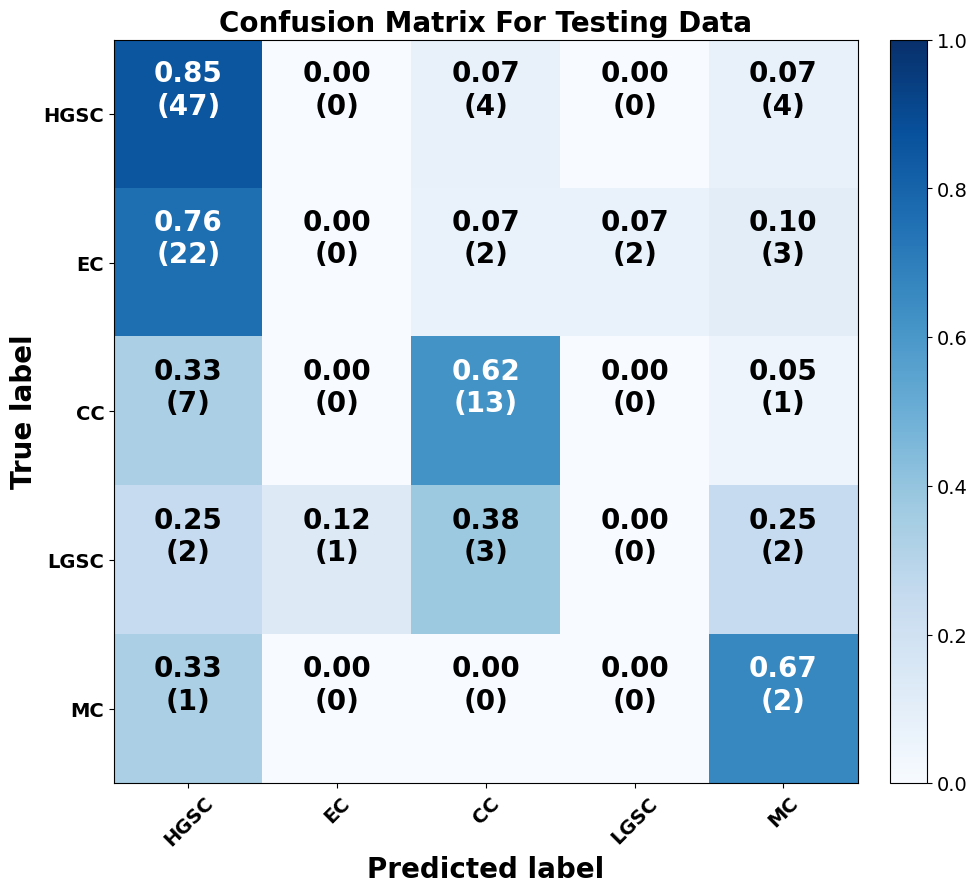

In [17]:
# ResNet50
from src.models import ResNet50

Param = {'Exp_name': 'ResNet50',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 5e-5,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
resnet50 = ResNet50()
resnet50 = resnet50.to(device)
resnet50.apply(initialize_weights_cnn)

loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(resnet50.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, resnet50, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])

[099/100 Time: 923.98s LR: 0.00005000] Train Acc: 517/541(95.56%) Loss: 0.0045 | Val Acc: 56/116(48.28%) loss: 0.0877
The best epoch: 98th  -->  Val Acc: 62.07 | Val Loss: 0.0558


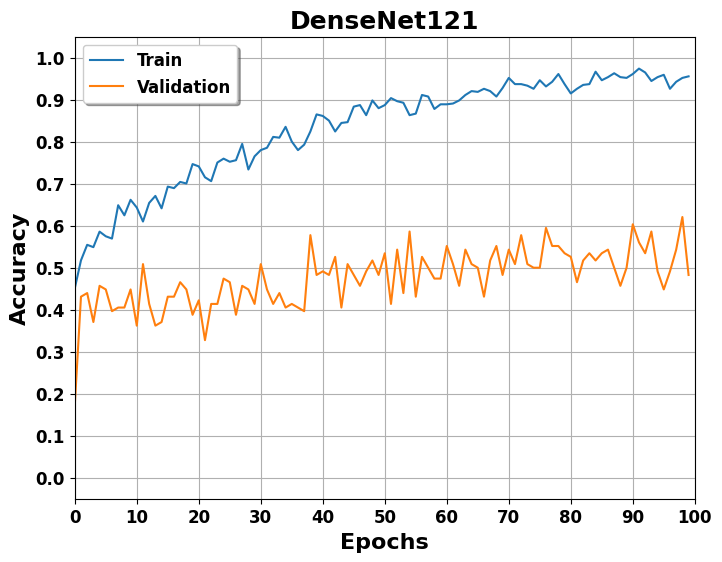

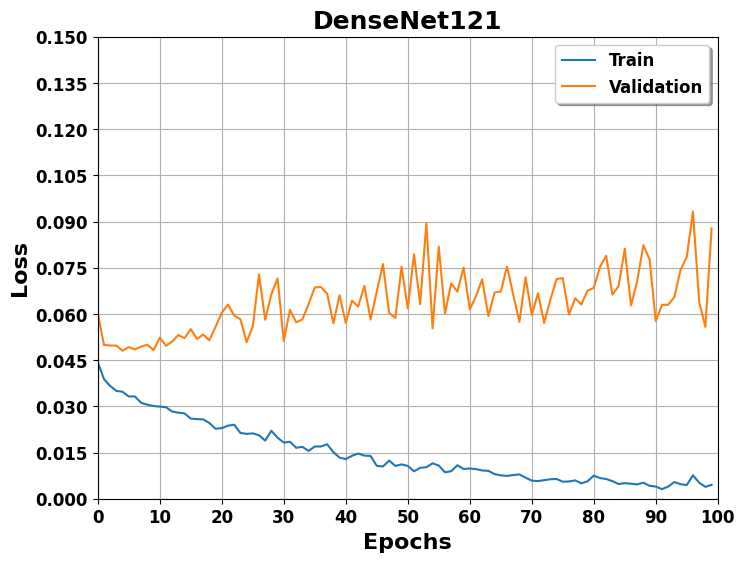

Testset Acc: 78/116 (67.24%)
Testset Loss: 0.0476

              precision    recall  f1-score   support

        HGSC     0.7031    0.8182    0.7563        55
          EC     0.8235    0.4828    0.6087        29
          CC     0.6522    0.7143    0.6818        21
        LGSC     0.4000    0.2500    0.3077         8
          MC     0.2857    0.6667    0.4000         3

    accuracy                         0.6724       116
   macro avg     0.5729    0.5864    0.5509       116
weighted avg     0.6923    0.6724    0.6658       116


Confusion Matrix: 
 [[45  1  7  1  1]
 [10 14  0  1  4]
 [ 4  1 15  1  0]
 [ 4  1  1  2  0]
 [ 1  0  0  0  2]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

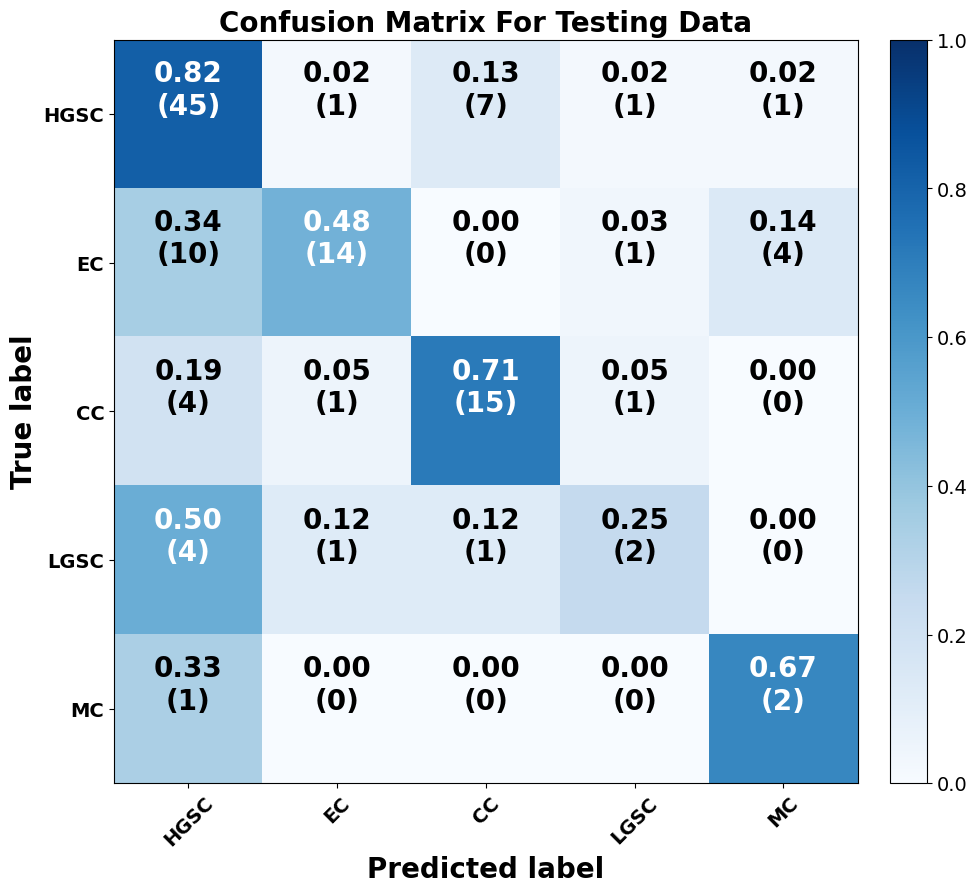

In [18]:
# DenseNet121
from src.models import DenseNet121

Param = {'Exp_name': 'DenseNet121',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 5e-5,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
densenet121 = DenseNet121()
densenet121 = densenet121.to(device)
densenet121.apply(initialize_weights_cnn)

loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(densenet121.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, densenet121, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])

[099/100 Time: 958.39s LR: 0.00005000] Train Acc: 372/541(68.76%) Loss: 0.0243 | Val Acc: 51/116(43.97%) loss: 0.0528
The best epoch: 92th  -->  Val Acc: 50.86 | Val Loss: 0.0506


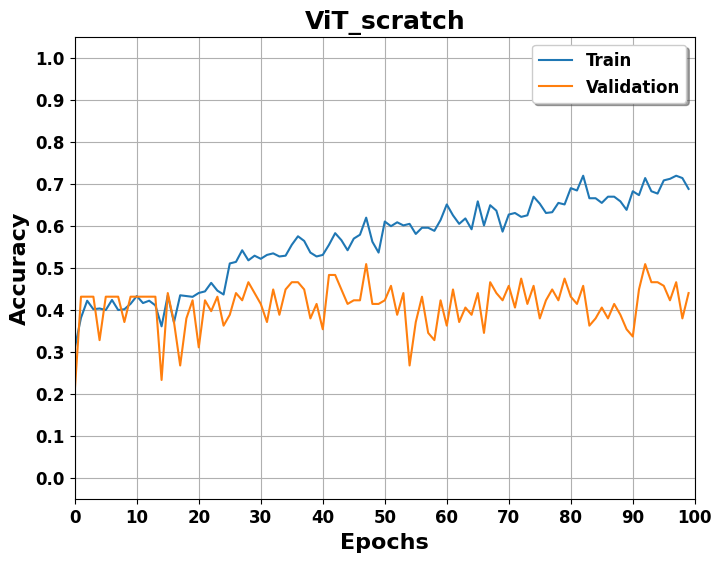

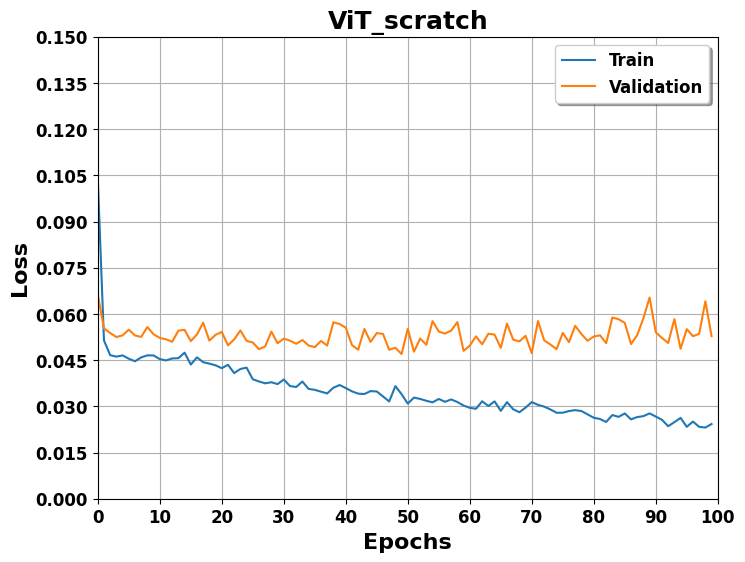

Testset Acc: 66/116 (56.90%)
Testset Loss: 0.0371

              precision    recall  f1-score   support

        HGSC     0.7000    0.6364    0.6667        55
          EC     0.4103    0.5517    0.4706        29
          CC     0.8000    0.5714    0.6667        21
        LGSC     0.6667    0.2500    0.3636         8
          MC     0.1111    0.3333    0.1667         3

    accuracy                         0.5690       116
   macro avg     0.5376    0.4686    0.4668       116
weighted avg     0.6281    0.5690    0.5838       116


Confusion Matrix: 
 [[35 13  3  1  3]
 [10 16  0  0  3]
 [ 2  6 12  0  1]
 [ 3  2  0  2  1]
 [ 0  2  0  0  1]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

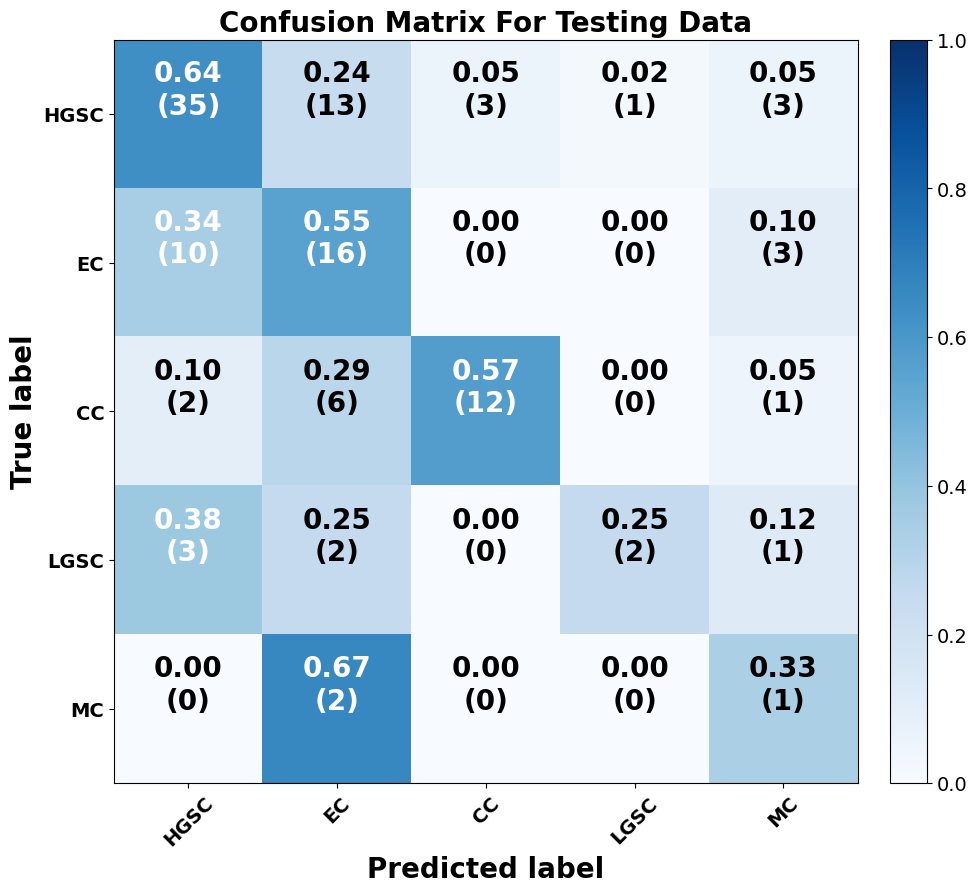

In [19]:
# ViT

Param = {'Exp_name': 'ViT_scratch',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 5e-5,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

vit_scratch = ViT(image_size = config.img_size,
        patch_size = 16,
        num_classes = config.num_classes,
        dim = 1024,
        depth = 6,
        heads = 8,
        mlp_dim = 2048
        )
vit_scratch = vit_scratch.to(device)
vit_scratch.apply(initialize_weights)

loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(vit_scratch.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, vit_scratch, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])

##### ***Fine-tuning***

[099/100 Time: 990.21s LR: 0.00005000] Train Acc: 440/541(81.33%) Loss: 0.0162 | Val Acc: 62/116(53.45%) loss: 0.0532
The best epoch: 83th  -->  Val Acc: 54.31 | Val Loss: 0.0470


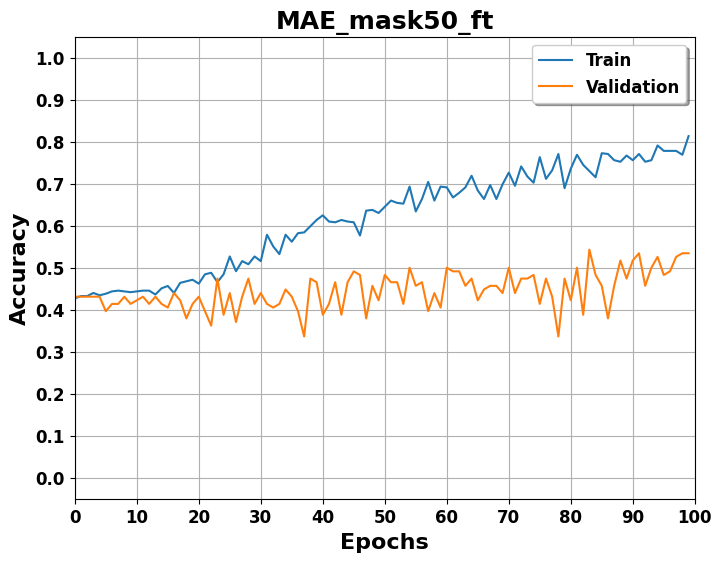

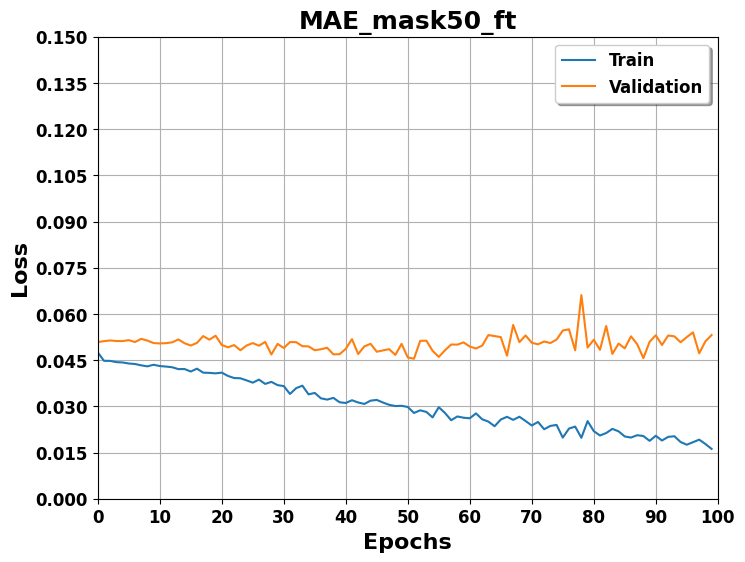

Testset Acc: 66/116 (56.90%)
Testset Loss: 0.0407

              precision    recall  f1-score   support

        HGSC     0.6452    0.7273    0.6838        55
          EC     0.4545    0.3448    0.3922        29
          CC     0.6190    0.6190    0.6190        21
        LGSC     0.6667    0.2500    0.3636         8
          MC     0.1250    0.3333    0.1818         3

    accuracy                         0.5690       116
   macro avg     0.5021    0.4549    0.4481       116
weighted avg     0.5808    0.5690    0.5641       116


Confusion Matrix: 
 [[40  6  5  1  3]
 [13 10  3  0  3]
 [ 3  4 13  0  1]
 [ 4  2  0  2  0]
 [ 2  0  0  0  1]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

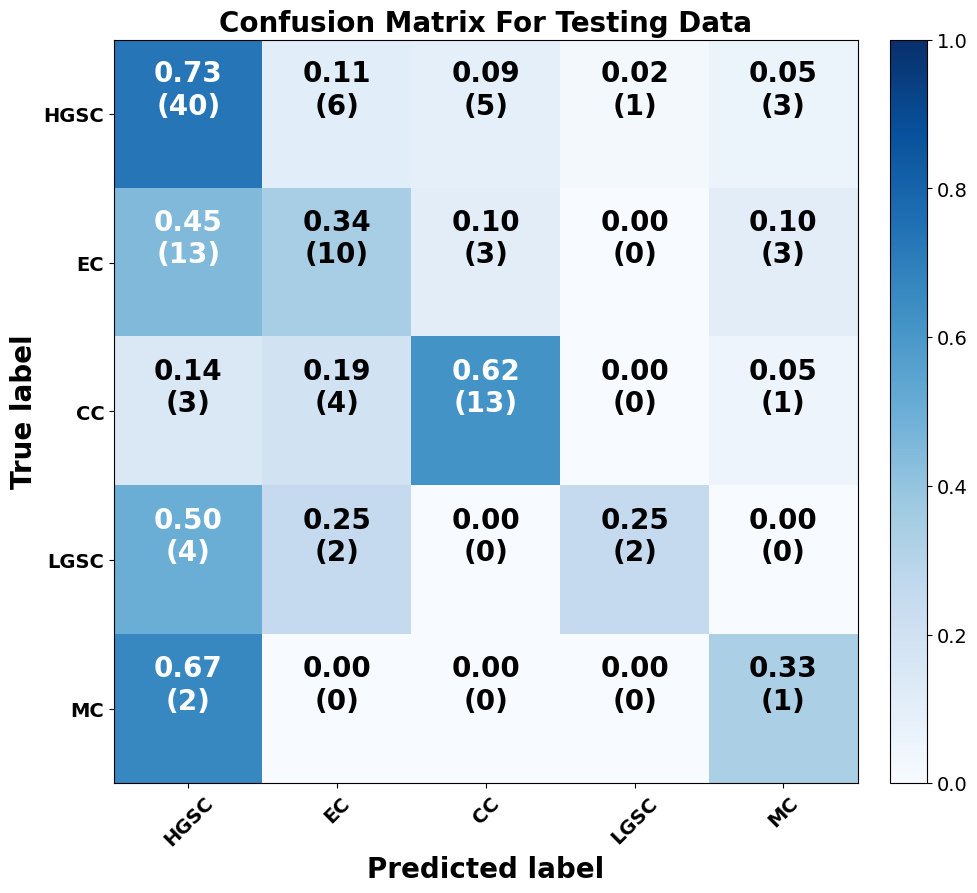

In [34]:
# mask ratio 50%

# load pre-trained model
checkpoint_model_path = current_result_dir + 'Best_MAE_mask50.pkl'
checkpoint_model = torch.load(checkpoint_model_path, map_location='cpu')
mae_encoder = checkpoint_model.encoder

# manually initialize fc layer
trunc_normal_(mae_encoder.mlp_head.weight, std=2e-5)

Param = {'Exp_name': 'MAE_mask50_ft',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 5e-5,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae_encoder = mae_encoder.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(mae_encoder.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, mae_encoder, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])

[099/100 Time: 992.49s LR: 0.00005000] Train Acc: 419/541(77.45%) Loss: 0.0182 | Val Acc: 58/116(50.00%) loss: 0.0492
The best epoch: 87th  -->  Val Acc: 55.17 | Val Loss: 0.0434


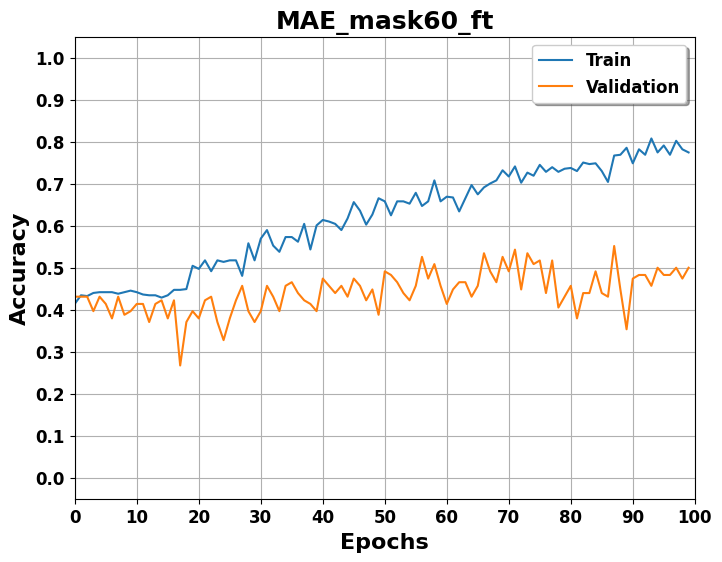

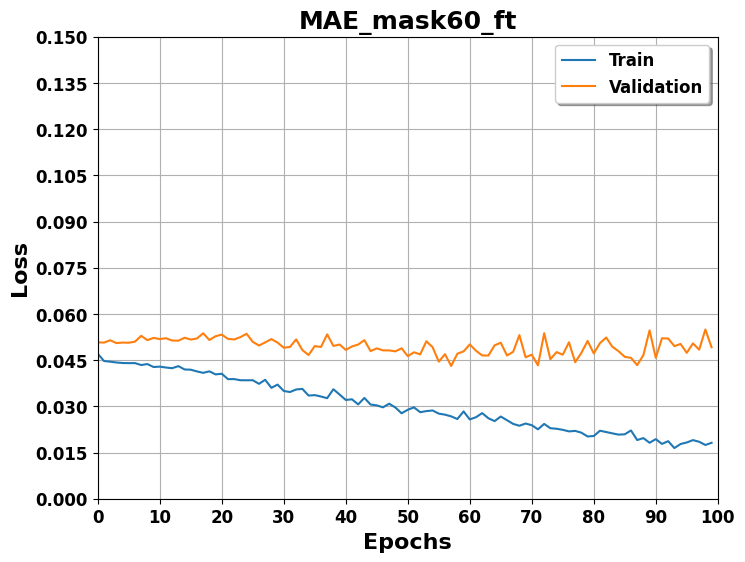

Testset Acc: 73/116 (62.93%)
Testset Loss: 0.0345

              precision    recall  f1-score   support

        HGSC     0.6667    0.8000    0.7273        55
          EC     0.5000    0.3448    0.4082        29
          CC     0.6154    0.7619    0.6809        21
        LGSC     1.0000    0.2500    0.4000         8
          MC     0.5000    0.3333    0.4000         3

    accuracy                         0.6293       116
   macro avg     0.6564    0.4980    0.5233       116
weighted avg     0.6344    0.6293    0.6081       116


Confusion Matrix: 
 [[44  7  4  0  0]
 [13 10  5  0  1]
 [ 3  2 16  0  0]
 [ 4  1  1  2  0]
 [ 2  0  0  0  1]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

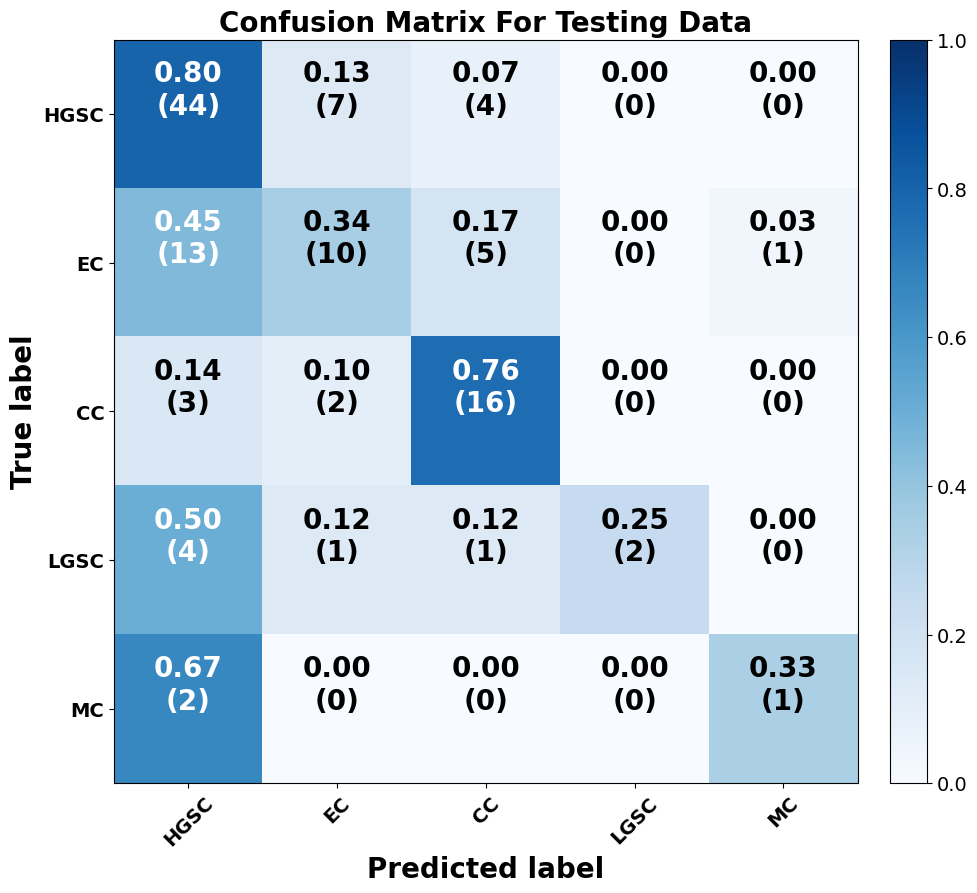

In [35]:
# mask ratio 60

# load pre-trained model
checkpoint_model_path = current_result_dir + 'Best_MAE_mask60.pkl'
checkpoint_model = torch.load(checkpoint_model_path, map_location='cpu')
mae_encoder = checkpoint_model.encoder

# manually initialize fc layer
trunc_normal_(mae_encoder.mlp_head.weight, std=2e-5)

Param = {'Exp_name': 'MAE_mask60_ft',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 5e-5,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae_encoder = mae_encoder.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(mae_encoder.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, mae_encoder, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])

[099/100 Time: 980.88s LR: 0.00005000] Train Acc: 418/541(77.26%) Loss: 0.0188 | Val Acc: 57/116(49.14%) loss: 0.0525
The best epoch: 97th  -->  Val Acc: 55.17 | Val Loss: 0.0541


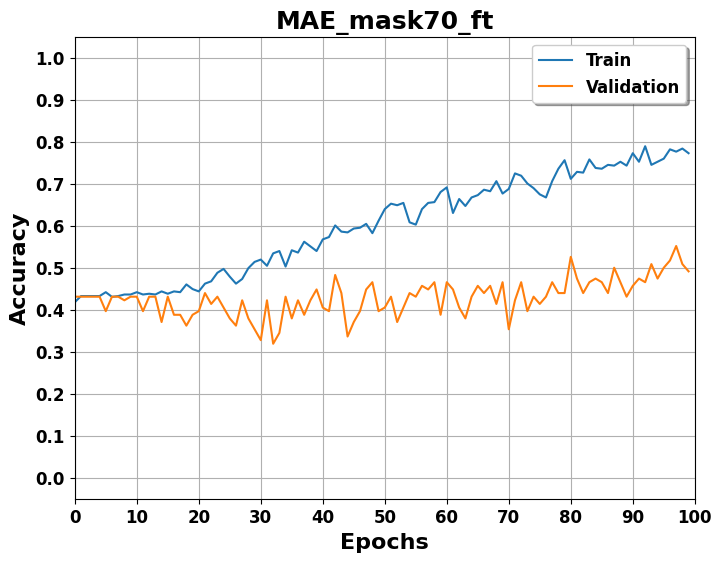

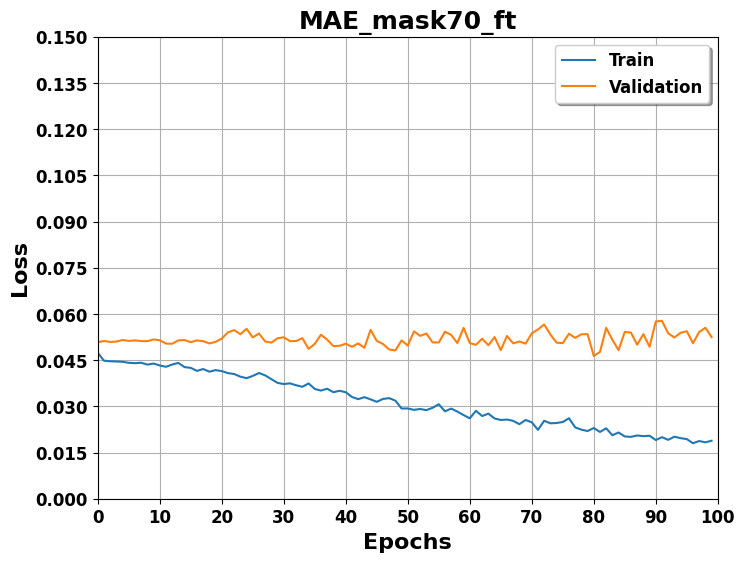

Testset Acc: 73/116 (62.93%)
Testset Loss: 0.0414

              precision    recall  f1-score   support

        HGSC     0.6765    0.8364    0.7480        55
          EC     0.5294    0.3103    0.3913        29
          CC     0.6364    0.6667    0.6512        21
        LGSC     0.5000    0.2500    0.3333         8
          MC     0.4000    0.6667    0.5000         3

    accuracy                         0.6293       116
   macro avg     0.5484    0.5460    0.5248       116
weighted avg     0.6131    0.6293    0.6063       116


Confusion Matrix: 
 [[46  2  4  2  1]
 [16  9  4  0  0]
 [ 3  3 14  0  1]
 [ 3  2  0  2  1]
 [ 0  1  0  0  2]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

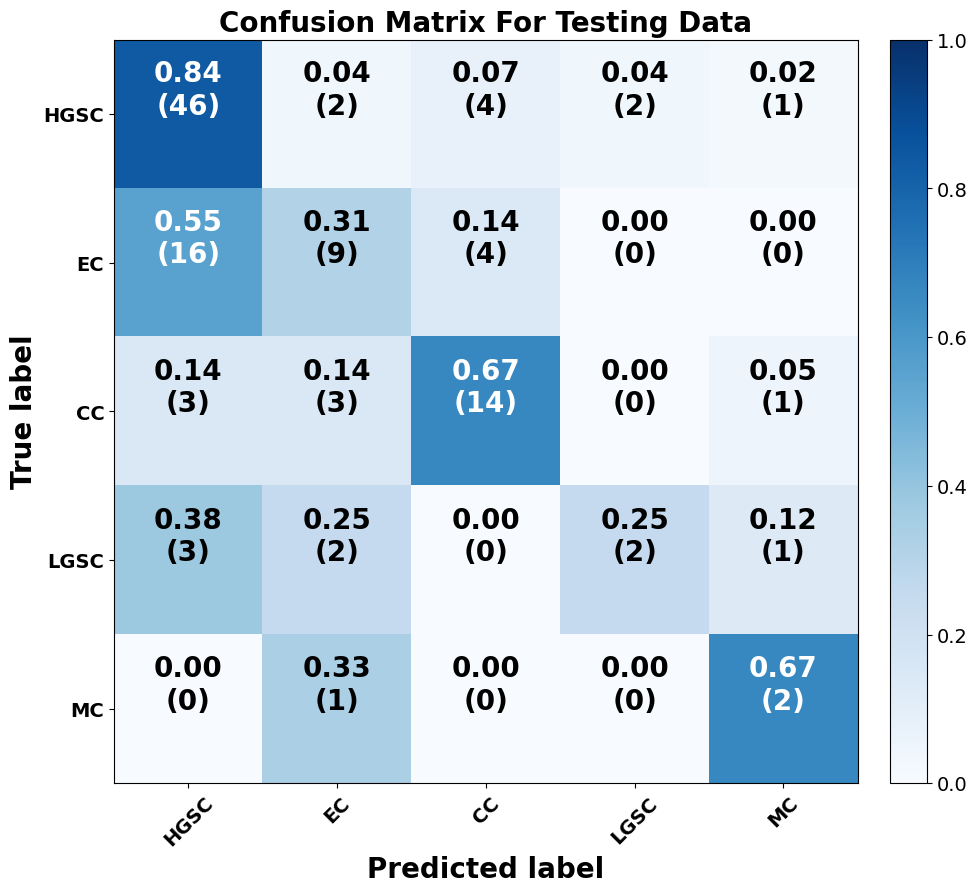

In [26]:
# mask ratio 70

# load pre-trained model
checkpoint_model_path = current_result_dir + 'Best_MAE_mask70.pkl'
checkpoint_model = torch.load(checkpoint_model_path, map_location='cpu')
mae_encoder = checkpoint_model.encoder

# manually initialize fc layer
trunc_normal_(mae_encoder.mlp_head.weight, std=2e-5)

Param = {'Exp_name': 'MAE_mask70_ft',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 5e-5,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae_encoder = mae_encoder.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(mae_encoder.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, mae_encoder, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])

[099/100 Time: 981.34s LR: 0.00010000] Train Acc: 354/541(65.43%) Loss: 0.0272 | Val Acc: 50/116(43.10%) loss: 0.0479
The best epoch: 95th  -->  Val Acc: 50.00 | Val Loss: 0.0457


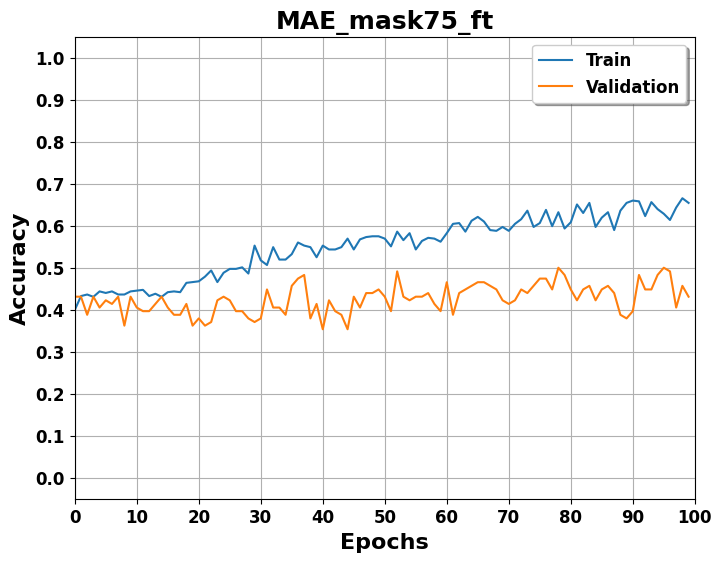

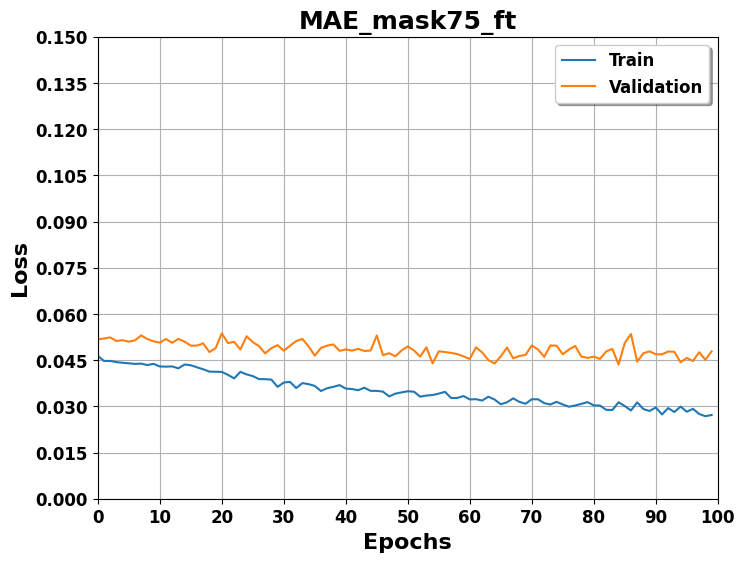

Testset Acc: 69/116 (59.48%)
Testset Loss: 0.0392

              precision    recall  f1-score   support

        HGSC     0.6429    0.8182    0.7200        55
          EC     0.5833    0.2414    0.3415        29
          CC     0.6316    0.5714    0.6000        21
        LGSC     0.6667    0.2500    0.3636         8
          MC     0.2500    1.0000    0.4000         3

    accuracy                         0.5948       116
   macro avg     0.5549    0.5762    0.4850       116
weighted avg     0.6174    0.5948    0.5708       116


Confusion Matrix: 
 [[45  4  4  0  2]
 [16  7  3  0  3]
 [ 4  1 12  1  3]
 [ 5  0  0  2  1]
 [ 0  0  0  0  3]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

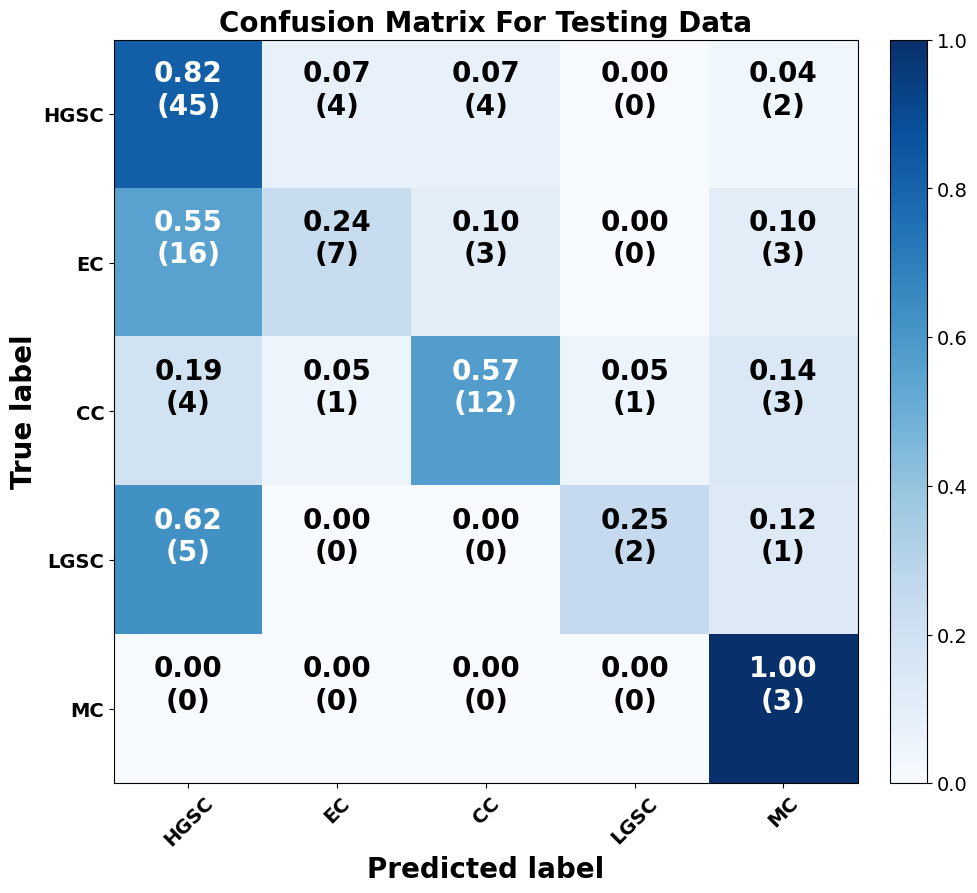

In [30]:
# mask ratio 75

# load pre-trained model
checkpoint_model_path = current_result_dir + 'Best_MAE_mask75.pkl'
checkpoint_model = torch.load(checkpoint_model_path, map_location='cpu')
mae_encoder = checkpoint_model.encoder

# manually initialize fc layer
trunc_normal_(mae_encoder.mlp_head.weight, std=2e-5)

Param = {'Exp_name': 'MAE_mask75_ft',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae_encoder = mae_encoder.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(mae_encoder.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, mae_encoder, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])

[099/100 Time: 982.90s LR: 0.00010000] Train Acc: 358/541(66.17%) Loss: 0.0278 | Val Acc: 54/116(46.55%) loss: 0.0472
The best epoch: 93th  -->  Val Acc: 52.59 | Val Loss: 0.0450


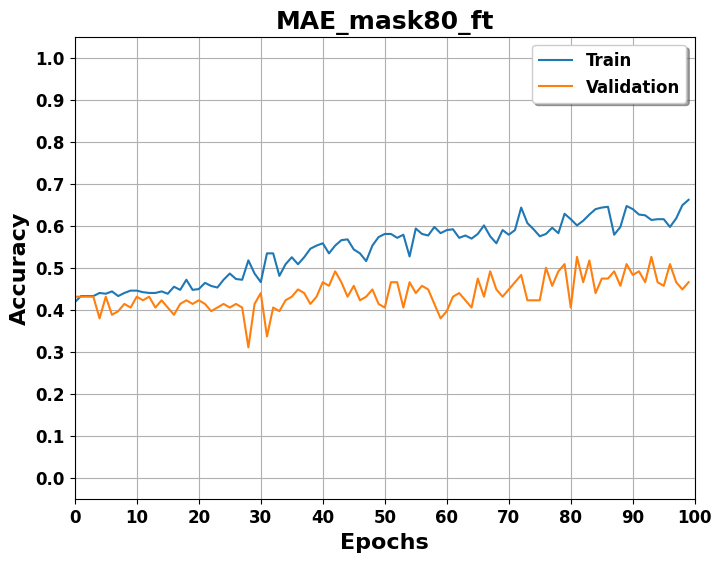

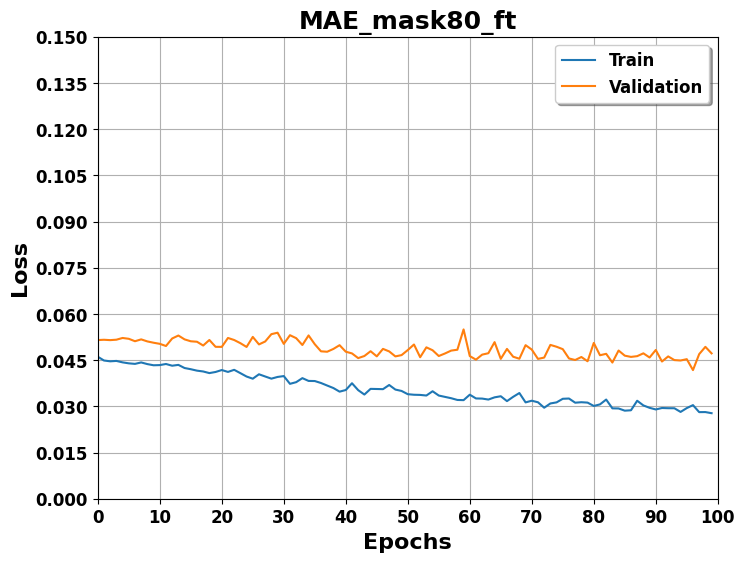

Testset Acc: 71/116 (61.21%)
Testset Loss: 0.0366

              precision    recall  f1-score   support

        HGSC     0.6618    0.8182    0.7317        55
          EC     0.5263    0.3448    0.4167        29
          CC     0.7368    0.6667    0.7000        21
        LGSC     0.2500    0.2500    0.2500         8
          MC     0.0000    0.0000    0.0000         3

    accuracy                         0.6121       116
   macro avg     0.4350    0.4159    0.4197       116
weighted avg     0.5960    0.6121    0.5951       116


Confusion Matrix: 
 [[45  4  1  5  0]
 [14 10  3  1  1]
 [ 4  2 14  0  1]
 [ 3  2  1  2  0]
 [ 2  1  0  0  0]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

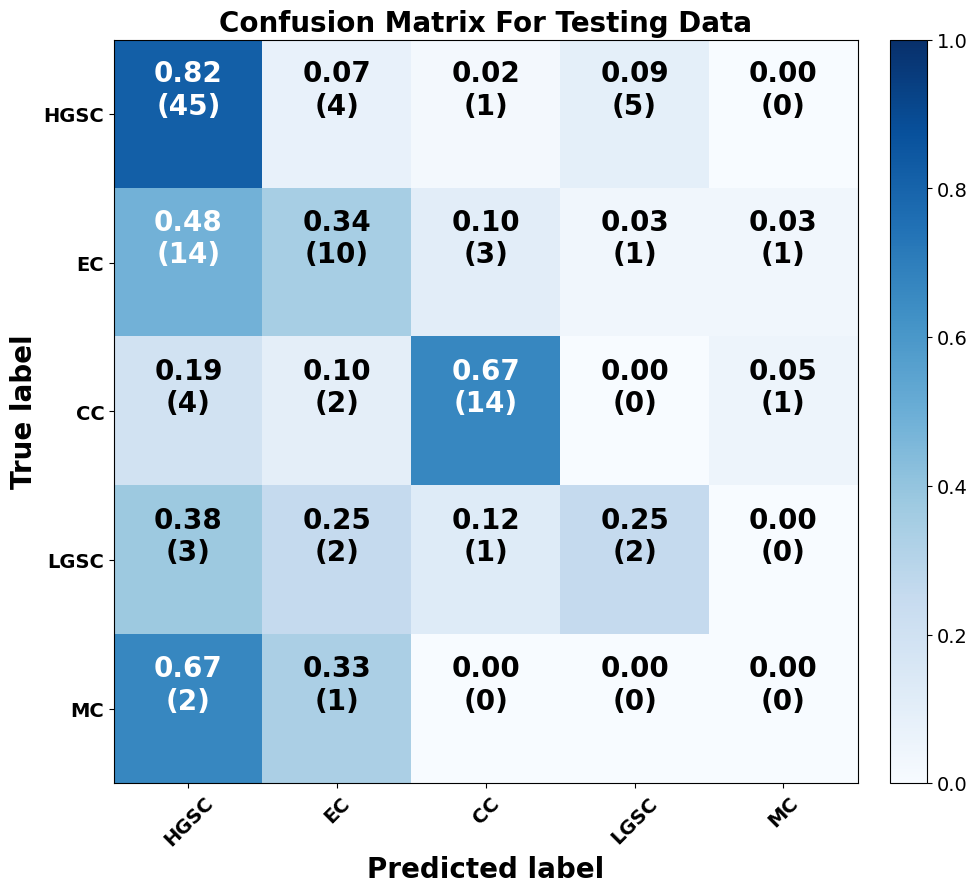

In [28]:
# mask ratio 80

# load pre-trained model
checkpoint_model_path = current_result_dir + 'Best_MAE_mask80.pkl'
checkpoint_model = torch.load(checkpoint_model_path, map_location='cpu')
mae_encoder = checkpoint_model.encoder

# manually initialize fc layer
trunc_normal_(mae_encoder.mlp_head.weight, std=2e-5)

Param = {'Exp_name': 'MAE_mask80_ft',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 5e-5,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae_encoder = mae_encoder.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(mae_encoder.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, mae_encoder, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])

[099/100 Time: 987.49s LR: 0.00010000] Train Acc: 304/541(56.19%) Loss: 0.0336 | Val Acc: 58/116(50.00%) loss: 0.0464
The best epoch: 99th  -->  Val Acc: 50.00 | Val Loss: 0.0464


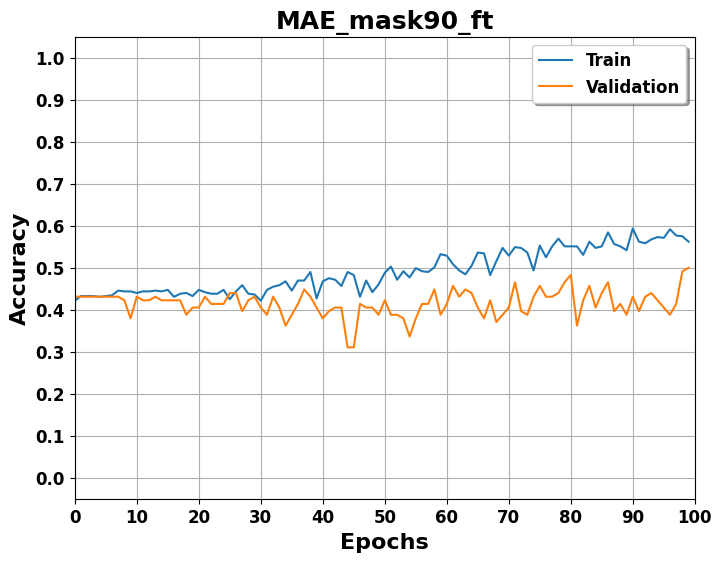

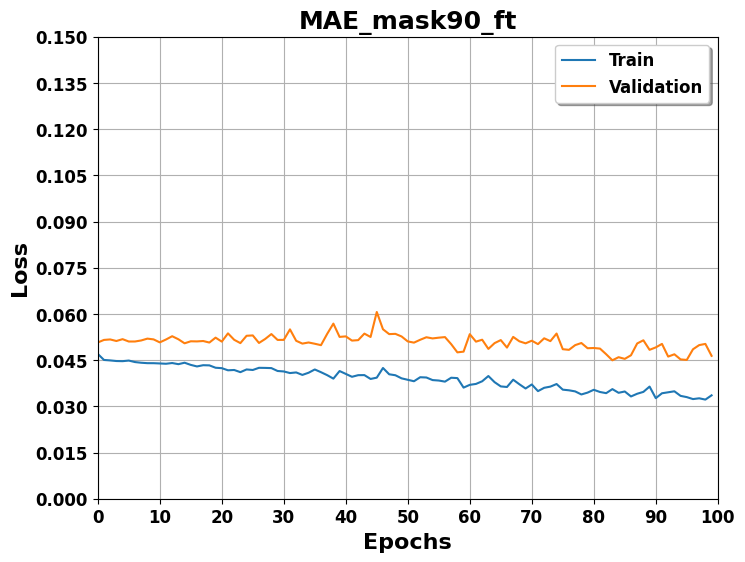

Testset Acc: 66/116 (56.90%)
Testset Loss: 0.0384

              precision    recall  f1-score   support

        HGSC     0.6000    0.7636    0.6720        55
          EC     0.5000    0.3103    0.3830        29
          CC     0.5600    0.6667    0.6087        21
        LGSC     1.0000    0.1250    0.2222         8
          MC     0.0000    0.0000    0.0000         3

    accuracy                         0.5690       116
   macro avg     0.5320    0.3731    0.3772       116
weighted avg     0.5798    0.5690    0.5399       116


Confusion Matrix: 
 [[42  4  8  0  1]
 [17  9  3  0  0]
 [ 3  3 14  0  1]
 [ 5  2  0  1  0]
 [ 3  0  0  0  0]]

Normalized Confusion Matrix


<Figure size 600x600 with 0 Axes>

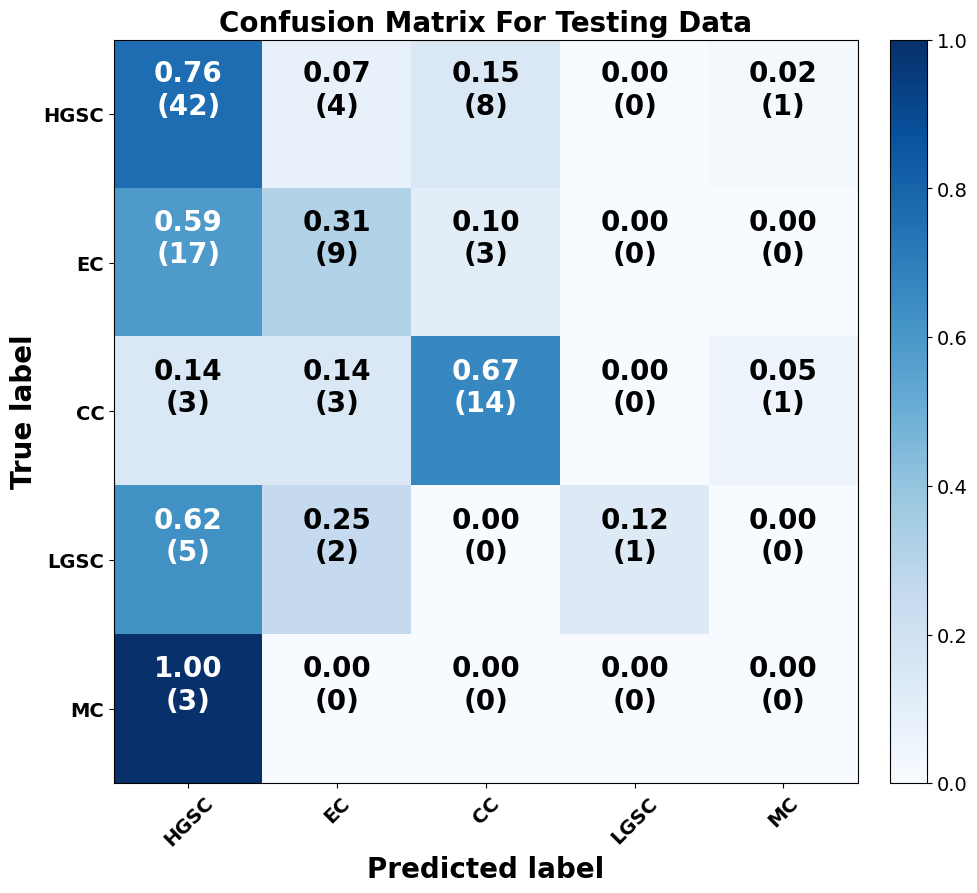

In [31]:
# mask ratio 90

# load pre-trained model
checkpoint_model_path = current_result_dir + 'Best_MAE_mask90.pkl'
checkpoint_model = torch.load(checkpoint_model_path, map_location='cpu')
mae_encoder = checkpoint_model.encoder

# manually initialize fc layer
trunc_normal_(mae_encoder.mlp_head.weight, std=2e-5)

Param = {'Exp_name': 'MAE_mask90_ft',
         'EPOCH': 100,
         'optim': 'AdamW', #Adam
         'LR': 1e-4,
         'L2_REG': 1e-4,
         'LRScheduler': None, # None, ReduceLROnPlateau
         'LRScheduler_start': 25, # ReduceLROnPlateau
         'LRScheduler_factor': 0.8, # ReduceLROnPlateau
         'LRScheduler_patience': 5, # ReduceLROnPlateau
         'LRScheduler_min_lr': 1e-8, # ReduceLROnPlateau
         }

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
mae_encoder = mae_encoder.to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(mae_encoder.parameters(), lr=Param['LR'], weight_decay=Param['L2_REG'])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=Param['LRScheduler_factor'],
                                                          patience=Param['LRScheduler_patience'], min_lr=Param['LRScheduler_min_lr'])

train(train_loader, val_loader, mae_encoder, Param,
      loss_func, optimizer, folder_dir = current_result_dir)

# Test
bestmodel_dir = current_result_dir + 'Best_' + Param['Exp_name'] + '.pkl'
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load(bestmodel_dir, map_location=torch.device(device))
best_model.eval()
test(test_loader, best_model, class_name=config.class2label, folder_path=current_result_dir, plot_name=Param['Exp_name'])